# Evaluierung des Agents

#### Imports

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from nes_py.wrappers import JoypadSpace
import torch
import numpy as np
from tqdm import tqdm
import gym
import gym_super_mario_bros
from gym.wrappers import (
    FrameStack,
    GrayScaleObservation,
    ResizeObservation,
    TransformObservation,
    Monitor,
)

# Import own Functions
from src.helper_functions.create_Plot import plot_results
from src.helper_functions.create_Agent import MarioAgentEpsilonGreedy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Initialisierung aller Komponenten

### Select the model

In [2]:
starting_point = os.path.join("models", "training_v2", "final_model.pth")

In [3]:
action_space = [
    ["NOOP"],
    ["A"],
    ["B"],
    ["right"],
    ["left"],
    ["right", "A"],
    ["right", "B"],
    ["right", "A", "B"],
]
stacking_number = 10
num_episodes = 10



eval_folder = os.path.join("res", "eval")
if not os.path.exists(eval_folder):
    os.makedirs(eval_folder)
vid_folder = os.path.join(eval_folder, "all_videos")
if not os.path.exists(vid_folder):
    os.makedirs(vid_folder)
plot_folder = os.path.join(eval_folder, "plots")
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

In [4]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, action_space)
env = Monitor(env, vid_folder, video_callable=lambda episode_id: True, force=True)
env = GrayScaleObservation(env, keep_dim=False)
env = ResizeObservation(env, shape=84)
env = TransformObservation(env, lambda obs: np.squeeze(obs, axis=-1))
env = TransformObservation(env, f=lambda x: x / 255.0)
env = FrameStack(env, num_stack=stacking_number)


state = env.reset()
state_shape = state.shape

In [5]:
agent = mario = MarioAgentEpsilonGreedy(
    num_actions=len(action_space),
    state_shape=state_shape,
    wantcuda=True,
    checkpoint_folder=None,
    model_folder=None,
    starting_point=starting_point,
)
agent.epsilon = 0.0
agent.model.eval()

reward_list = []
steps_list = []
q_list = []
loss_list = []
epsilon_list = []

Model loaded from models\training_v2\final_model.pth with epsilon 0.01


#### Loop to watch the model play

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\nicho\OneDrive\Dokumente\A - DHBW\6. Semester\AML\Abgaben\Coding\Reinforcement-Learning\src\helper_functions\create_Agent.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  state = torch.tensor(state, dtype=torch.float32, device=self.device)
c:\Users\nicho\OneDrive\Dokumente\A - DHBW\6. Semester\AML\Abgaben\Coding\Reinforcement-Learning\venv\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256
 10%|█         | 1/10 [01:08<10:20, 68.98s/it]

Episode 1 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 20%|██        | 2/10 [02:18<09:15, 69.44s/it]

Episode 2 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 30%|███       | 3/10 [03:28<08:07, 69.58s/it]

Episode 3 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 40%|████      | 4/10 [04:38<06:58, 69.76s/it]

Episode 4 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 50%|█████     | 5/10 [05:49<05:50, 70.15s/it]

Episode 5 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 60%|██████    | 6/10 [07:02<04:44, 71.05s/it]

Episode 6 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 70%|███████   | 7/10 [08:18<03:38, 72.90s/it]

Episode 7 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 80%|████████  | 8/10 [09:35<02:28, 74.18s/it]

Episode 8 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




 90%|█████████ | 9/10 [10:59<01:17, 77.30s/it]

Episode 9 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




100%|██████████| 10/10 [12:24<00:00, 74.43s/it]

Episode 10 abgeschlossen mit 3861 Schritten, Gesamtbelohnung: 887.0, Epsilon: 0.0




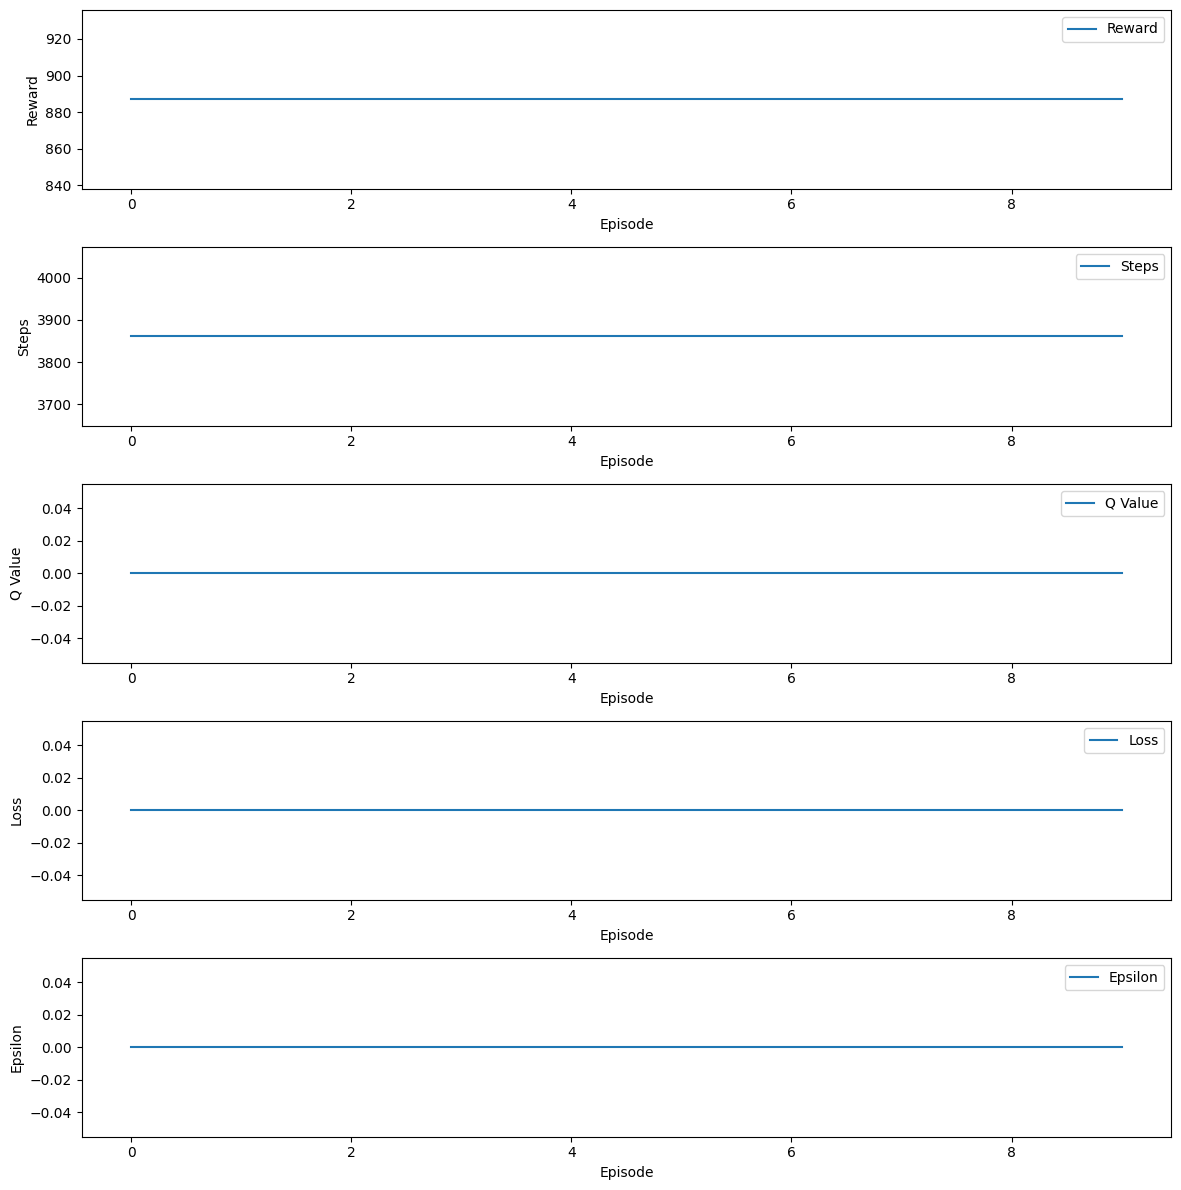

In [6]:
for episode in tqdm(range(1, num_episodes + 1)):
    state = env.reset()
    total_reward = 0
    steps = 0
    mean_episode_q = []
    mean_episode_loss = []
    resetnow = False
    # Initiate loop for the current episode to play the game until it ends
    while resetnow==False:
        # To visualize the game
        env.render()
        action = agent.selectAction(state)
        next_state, reward, resetnow, info = env.step(action)
        resetnow = resetnow
        agent.saveExp(state, action, next_state, reward, resetnow)
        q, loss = agent.learn_get_TDest_loss()
        state = next_state
        total_reward = total_reward + reward
        steps = steps + 1
        mean_episode_q.append(q)
        mean_episode_loss.append(loss)
    print(
        f"Episode {episode} abgeschlossen mit {steps} Schritten, Gesamtbelohnung: {total_reward}, Epsilon: {agent.epsilon}\n\n"
    )
    # Save the results of the current episode
    reward_list.append(total_reward)
    steps_list.append(steps)
    q_list.append(np.mean(mean_episode_q))
    loss_list.append(np.mean(mean_episode_loss))
    epsilon_list.append(agent.epsilon)

# Plot the results of all episodes at the defined intervals
plot_results(
    reward_list,
    steps_list,
    q_list,
    loss_list,
    epsilon_list,
    os.path.join(plot_folder, f"plot_{episode}.png"),
)

# Close the environment
env.close()